<h1> Documentation/Walkthrough Code</h1>
This notebook gives an overview of the different capabilities of the buildpipe package. <br>
Every code cell will be supported by a few remarks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from brandaid_buildpipe import Pipe
from brandaid_buildpipe import Processing
from brandaid_buildpipe import Estimator
from brandaid_buildpipe import ShowResults
from brandaid_buildpipe import Baseline
from brandaid_buildpipe.MlflowDecorators import list_dead_mlflow_exps, delete_all_runs_in_exp, check_exp_name
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor

No File found, package may be not in local pycharm directory, Please use: %env MLFLOW_TRACKING_USERNAME=MY_VALUE, %env MLFLOW_TRACKING_PASSWORD=MY_VALUE, if youare using a jupyter notebook, that is in the cloud or over Anaconda.


<h3> Loading Data</h3>
We load an artificial time series data set about traffic volume from the url: <br>
<a href>https://archive.ics.uci.edu/ml/machine-learning-databases/00492/ </a> <br>
shape: 48204, 9

In [3]:
delete_all_runs_in_exp()
data = pd.read_csv("Metro_Traffic.csv")
data.rename(columns={"date_time": "sendetag"}, inplace=True)

No runs in Experiment to delete.


<h3> Preprocessing data / Gaussian Seasonality </h3>
The Processing class offers the possibility to create a gaussian seasonality for your time features <br>
For example, you can tell the method, that a 24 hour day should get exactly one or several peaks of gaussian dummies<br>
These dummies shall reflect seasonality, e.g. normally you would set a seasonal dummy for 12 a.m. with a 1 to activate it in the data.
But this not always makes sense. A seasonality not normally, in terms of hours, jump from zero at 11 a.m to 1 at noon 12. a.m. The gaussian dummies, however, can fade out.
Future upgrades will also allow to shape the bell curve.<br>
<br>
The following example will show a two bump seasonality for each day in the data set. <br>
<br>
 - the blut line plot shows a bump at 0.00 a.m. in the morning <br>
 - the red line plot shows a bump at 12.00 a.m. noon

The 0 and 1 columns represent the gaussian dummies. They are repeating itself over time, and stay the same.

In [4]:
process = Processing()
data_for_baseline_season = process.create_gaussian_seasonality(data, "sendetag", 2)

Found sendetag


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


              sendetag holiday    temp  rain_1h  snow_1h  clouds_all  \
0  2012-10-02 09:00:00    None  288.28      0.0      0.0        40.0   
1  2012-10-02 10:00:00    None  289.36      0.0      0.0        75.0   
2  2012-10-02 11:00:00    None  289.58      0.0      0.0        90.0   
3  2012-10-02 12:00:00    None  290.13      0.0      0.0        90.0   
4  2012-10-02 13:00:00    None  291.14      0.0      0.0        75.0   
5  2012-10-02 14:00:00    None  291.72      0.0      0.0         1.0   
6  2012-10-02 15:00:00    None  293.17      0.0      0.0         1.0   
7  2012-10-02 16:00:00    None  293.86      0.0      0.0         1.0   
8  2012-10-02 17:00:00    None  294.14      0.0      0.0        20.0   
9  2012-10-02 18:00:00    None  293.10      0.0      0.0        20.0   
10 2012-10-02 19:00:00    None  290.97      0.0      0.0        20.0   
11 2012-10-02 20:00:00    None  289.38      0.0      0.0         1.0   
12 2012-10-02 21:00:00    None  288.61      0.0      0.0        

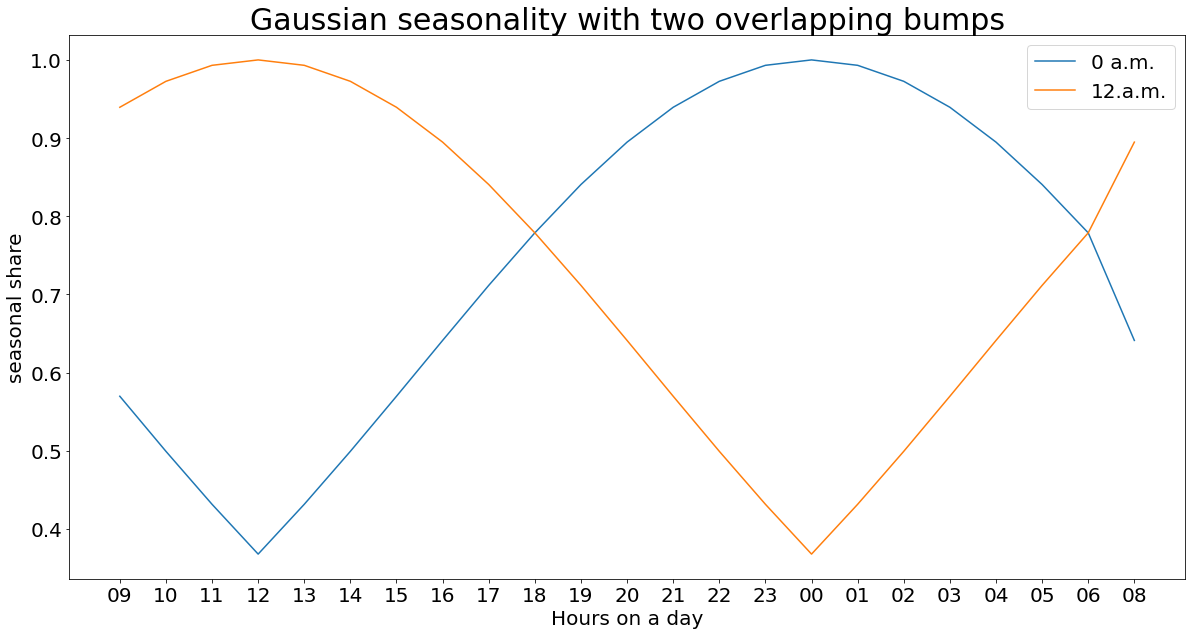

In [5]:
%matplotlib inline
print(data_for_baseline_season.head(n=48))
plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = '20'
plt.plot(data_for_baseline_season.iloc[:23, 0].dt.strftime("%H"),
         data_for_baseline_season.iloc[:23, 9], label="0 a.m.")
plt.plot(data_for_baseline_season.iloc[:23, 0].dt.strftime("%H"),
         data_for_baseline_season.iloc[:23, 10], label="12.a.m.")
plt.xlabel('Hours on a day')
plt.ylabel("seasonal share")
plt.title('Gaussian seasonality with two overlapping bumps', fontsize=30)
plt.legend()
plt.show()

<h3> Labelencoding </h3>
We can also labelencode categorical features and list their encoding. <br>
However the overview is only useful if you have only few labels.
Keep in mind that this is the only real preprocessing as the task of the original validation pipe is to
align estimators, folds, results and psuh it into mlflow.

In [6]:
cat_feats = ["holiday", "weather_main", "weather_description"]
data_cat_feats = process.preprocess_cat_feats(data_for_baseline_season, *cat_feats)
data_cat_list = process.list_cat_feats(data_cat_feats, cat_feats)
data_cat_feats.dropna(axis=0, inplace=True)  # ebm cant work with NaN

data_season_trend = data_cat_feats

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,Christmas Day,Columbus Day,Independence Day,Labor Day,Martin Luther King Jr Day,Memorial Day,New Years Day,None,State Fair,Thanksgiving Day,...,None,None,None,None,None,None,None,None,None,None
1,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,...,None,None,None,None,None,None,None,None,None,None
2,SQUALLS,Sky is Clear,broken clouds,drizzle,few clouds,fog,freezing rain,haze,heavy intensity drizzle,heavy intensity rain,...,sleet,smoke,snow,thunderstorm,thunderstorm with drizzle,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain


<h3> Creating trend Data </h3>
We can also create a predetermined trend. This trend will be more flexible in the future <br>
with patsy formulas. For the example we will forfeit the trend. It will only create a trend variable that starts from the beginning
of the train set and rises.<br>
<br>

<code>
data_season_trend = process.create_trend(data_cat_feats)
</code>

<h3> Combining Meta Estimators for a pipeline</h3>
The next few lines show different possibilities of combined trend/seasonal models with a residual model <br>
<br> With the sklearn pipeline every combination of estimators is possible
<br> For sake of simplicity and speed, we will use the last estimator combination of <u>LinearRegression</u> and <u>HistGradientBoostingRegressor</u>.
The other cells will thus not be exxecuted. They are only for presentation only.
<br>
<br><span style="color: red">Hint 1: </span> The Estimator class needs a column index (<code>time_columns_start=7</code>)so that the process knows where to split
the data in two halves. <br>
That means that all time features you want to consider in your trend/season model should be at the end of your data file. <br>
There is also a parameter called <code>reuse_time_feats=True</code> which can be used in the instance to tell the
fit/predict <br> process that you want to reuse the time features again in the residual model, to capture further effects of time.
You could also say, to capture time effects twice. In the trend/Season model AND the residual model<br>
<br>

<br><span style="color: red">Hint 2: </span> For classification tasks: Keep in mind that the Meta Estimator can not mix up
<u>Regression</u> Trend/Season Models and <u>Classification</u> Residual Models. Also predict method for classification tasks is <strong> not </strong> <code>predict_proba atm</code><br>
<br>
For our example, we will activate the latter parameter/estimator setup (LinearReg/HistGradientBoosting). You will see this combination at the end of example setups, if you do not want to reuse time features, leave it out. Keep in mind, <br>
that the results class and the baseline classes also need this parameter, if you want to reuse time features.

In [ ]:
# Trend/Season with Linear Regression
# Residual Model with EBM

estimator = Estimator(
    trend_season_model=LinearRegression(),
    residual_model=ExplainableBoostingRegressor(),
    time_columns_start=7,
    reuse_time_feats=True
)

estimator__param = {
        "trend_season": {
            "Estimator__trend_season_model__positive": [True]
        },
        "residual": {
            "Estimator__residual_model__max_leaves": [8, 16],
            "Estimator__residual_model__max_bins": [128, 256]
        }
    }

In [ ]:
# Trend/Season with Lasso
# Residual Model with EBM without resuing time features in residual

estimator = Estimator(
    trend_season_model=Lasso(),
    residual_model=ExplainableBoostingRegressor(),
    time_columns_start=7
)

estimator__param = {
        "trend_season": {
            "Estimator__trend_season_model__max_iter": [2500, 5000],
            "Estimator__trend_season_model__tol": [0.01]
        },
        "residual": {
            "Estimator__residual_model__max_leaves": [8],
            "Estimator__residual_model__max_bins": [128]
        }
    }

In [ ]:
# Trend/Season with Ridge
# Residual Model with CatBoost

estimator = Estimator(
    trend_season_model=Ridge(),
    residual_model=CatBoostRegressor(),
    time_columns_start=7,
    reuse_time_feats=True
)

estimator__param = {
        "trend_season": {
            "Estimator__trend_season_model__max_iter": [2500, 5000],
            "Estimator__trend_season_model__tol": [0.01],
            "Estimator__trend_season_model__solver": ["svd", "saga"]
        },
        "residual": {
            "Estimator__residual_model__learning_rate": [0.02, 0.03, 0.1],
            "Estimator__residual_model__l2_leaf_reg": [2, 3, 4]
        }
    }

In [ ]:
# Trend/Season and Residual with Classifiers
# Keep in Mind that Meta Estimators can not mix Regression and Classification Tass

estimator_classification = Estimator(
    trend_season_model=RandomForestClassifier(),
    residual_model=HistGradientBoostingClassifier(),
    time_columns_start=8
)

estimator__params_classifications = {
    "trend_season": {
        "MetaEstimator__trend_season_model__n_estimators": [100, 200],
        "MetaEstimator__trend_season_model__max_depth": [4, 6]

    },
    "residual": {
        "MetaEstimator__residual_model__learning_rate": [0.02, 0.1],
        "MetaEstimator__residual_model__max_bins": [128]
    }
}

In [ ]:
# OptunaSearch Setup:
# Trend/Season with Linear
# Residual Model with ExplainableBoosting

estimator__param = {
        "trend_season": {
            "MetaEstimator__trend_season_model__positive": optuna.distributions.CategoricalDistribution([False, True])
        },
        "residual": {
            "MetaEstimator__residual_model__max_bins": optuna.distributions.IntUniformDistribution(128, 255)
        }
    }

In [7]:
# Trend/Season with Linear
# Residual Model with HistGradientBoosting
# We use this setup for our fitting in the notebook
estimator = Estimator(trend_season_model=LinearRegression(),
                      residual_model=HistGradientBoostingRegressor(),
                      time_columns_start=7)

estimator__param = {
        "trend_season": {
            "MetaEstimator__trend_season_model__positive": [True]
        },
        "residual": {
            "MetaEstimator__residual_model__learning_rate": [0.02, 0.1],
            "MetaEstimator__residual_model__max_bins": [128]
        }
    }

<h3> The Pipeline Object with Expanding Window </h3>
When we have defined estimators and parameters we then, create a pipe object. <br>
The pipe object needs:

- the whole data set
- the name of the target variable
- instance of the Estimator class
- hyperparameters for the MetaEstimator
- Which time series cv technique you want to use ("Expanding", Sliding")
- hte pandas time delta which tells the splitting in the pipeline object, how big each fold should be.
- your date column
- In case of Expanding its optional, but otherwise, the window_size (train), the sliding size, the forecast soze (test)

Possible hyperparameters can be viewed by the get_params method of every estimator 8may not work for every non-scikit learn estimator)
https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

In [ ]:
# Example with Expanding Window and weekly timedelta of 10 weeks
# pandas time delta https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html
pipe = Pipe(
    data=data_season_trend,
    target="traffic_volume",
    estimator=estimator,
    params=estimator__param,
    window_type="Expanding",
    test_level="10 W",
    date_column="sendetag"
)

<h3> The Pipeline Object with Sliding Window </h3>
The pipe object can make use of further parameters if you like to choose a sliding window<br>
| + + + + + x x x - - - |<br>
| - + + + + + x x x - - |<br>
| - - + + + + + x x x - |<br>
| - - - + + + + + x x x |<br>

*****

"+" = length of training window (param called window_size, here equals 5) <br>
"x" = length of test window (param called forecats_size, here equals 3)<br>
"-" = remaining or already checked folds <br>
sliding size = 1

It is also possible to change the sliding parameter:
Here we have a sliding parameter of 3. <br>
| + + x x - - - - - - - |<br>
| - - - + + x x - - - - |<br>
| - - - - - - + + x x - |<br>

Remaining folds/windows will <strong>be cut off for training</strong>. If you want to compare your other Estimators against the Meta Estimator, choose the same Splitter.
For the sake of simplictity we just use the old splitter, which is the expanding window splitter.

In [ ]:
# Example with Sliding Window and OptunaSearchCV
pipe = Pipe(
    data=data_season_trend,
    target="traffic_volume",
    estimator=estimator,
    params=estimator__param,
    window_type="Sliding",
    test_level="276 days",
    date_column="sendetag",
    window_size=2,
    sliding_size=1,
    forecast_size=2,
    search_technique="OptunaSearchCV"
)

In [8]:
# We use for the example an Expanding window with a daily timedelta
pipe = Pipe(
    data=data_season_trend,
    target="traffic_volume",
    estimator=estimator,
    params=estimator__param,
    window_type="Expanding",
    test_level="276 days",
    date_column="sendetag"
)


<h3> Fitting Meta Estimator</h3>
Next we fit the combined model <br>
<span style="color: red">Hint: </span>: We can give the pipeline further pipeline parameters, for the sklearn pipeline
function, like the verbose parameter <br> But you definetely need a scoring! parameter. In case of a regression task e.g. r2 or accuracy in case you want to do a classification.
We then show the results of the fit process and the prediction.
<br>
<br>
Keep in mind that we again need
the time feature split column (<code>time_columns_start=7</code>), and if we want to reuse time features, another parameter <code>time_feats_in_res="yes"</code>.
Leave it out, if you dont want to use it. Keep in mind that reusing time features in the residual model, leads to permutation tests
where you have the time feats in the baseline model (HistGradientBoosting). if you do not reuse them, the perm. importance plots. will not show them.
Whatever you prefer.

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Fitting 4 folds for each of 2 candidates, totalling 8 fits
length of window y: 8038
length of window X: 8038
[CV 1/4] END MetaEstimator__residual_model__learning_rate=0.02, MetaEstimator__residual_model__max_bins=128, MetaEstimator__trend_season_model__positive=True;, score=0.614 total time=   4.5s
length of window y: 16073
length of window X: 16073
[CV 2/4] END MetaEstimator__residual_model__learning_rate=0.02, MetaEstimator__residual_model__max_bins=128, MetaEstimator__trend_season_model__positive=True;, score=0.621 total time=   2.8s
length of window y: 24108
length of window X: 24108
[CV 3/4] END MetaEstimator__residual_model__learning_rate=0.02, MetaEstimator__residual_model__max_bins=128, MetaEstimator__trend_season_model__positive=True;, score=0.589 total time=   2.8s
length of window y: 32143
length of window X: 32143
[CV 4/4] END MetaEstimator__residual_model__learning_rate=0.02, MetaEstimator__residual_model__max_bins=128, MetaEstimator__trend_season_model__positive=True;, sc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_MetaEstimator__residual_model__learning_rate,param_MetaEstimator__residual_model__max_bins,param_MetaEstimator__trend_season_model__positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,3.175782,0.767366,0.027826,0.001448,0.02,128,True,{'MetaEstimator__residual_model__learning_rate...,0.613723,0.620571,0.589401,0.628649,0.613086,0.014659,1
1,3.332366,0.433140,0.031663,0.004092,0.1,128,True,{'MetaEstimator__residual_model__learning_rate...,0.579644,0.610374,0.581441,0.624795,0.599064,0.019220,2


preparing permutation importance plots ...


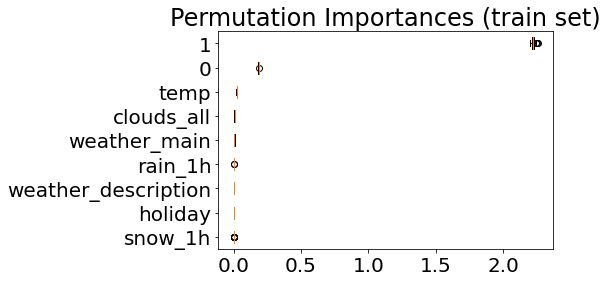

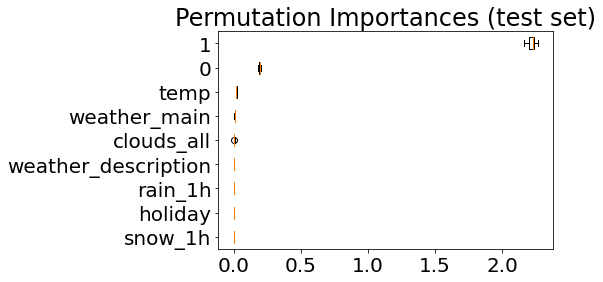

Best predicted R2 score (predict): 0.6192551026394184
Best predicted MAPE score (predict): 0.7969136310154953
Best predicted MdAPE score (predict): 716.2153240104848
Best predicted MSE score (predict): 1477300.8645297934
Best predicted MASE score (predict): 0.9999999999999999


In [9]:
# Results class needs extra information, how to deal with time features for showing results after the pipe process
model, X_train, X_test, y_train, y_test = pipe.fit_pipeline(verbose=5, scoring="r2")
pred = pipe.predict_pipeline(model)
show = ShowResults(
    model,
    X_train, X_test,
    y_train, y_test,
    time_columns_start=7,
    time_feats_in_res="yes"
)
show.show_model_results(pred)

Hint: When refit=True in the pipeline, which is a default option in sklearn, the best parameter combination from all cv's will be used on the whole data set, which then creates the best estimator output. 

<h3> Fitting Single Estimators</h3>
Next we fit both parts of the Estimator classes separately and compare each performance of the estimator on the same fold.
For this we create a baseline object that splits our Estimators and parameters in separate sklearn pipelines, while
keeping the fold structure of our Expanding or Sliding Window.<br>
<br> Keep in mind, that the baseline estimators allow also <code>RandomSearchCV</code> grids. For a better comparison we will not reuse time features, so you can see how the explained variance of both subestimators splits up between trend/season and
residual model

In [10]:
base = Baseline(
    data=data_season_trend,
    estimator_split=estimator,
    base_params=estimator__param,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    window_type="Expanding"
)

models_base, pred_base = base.fit_and_predict_partial_estimators(
    time_columns_start=7,
    verbose=5,
    scoring="r2"
)


******************

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ...LinearRegression__positive=True;, score=0.608 total time=   0.0s
[CV 2/4] END ...LinearRegression__positive=True;, score=0.623 total time=   0.0s
[CV 3/4] END ...LinearRegression__positive=True;, score=0.590 total time=   0.0s
[CV 4/4] END ...LinearRegression__positive=True;, score=0.620 total time=   0.0s

******************

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4] END HistGradientBoostingRegressor__learning_rate=0.02, HistGradientBoostingRegressor__max_bins=128;, score=0.024 total time=   4.4s
[CV 2/4] END HistGradientBoostingRegressor__learning_rate=0.02, HistGradientBoostingRegressor__max_bins=128;, score=0.043 total time=   3.9s
[CV 3/4] END HistGradientBoostingRegressor__learning_rate=0.02, HistGradientBoostingRegressor__max_bins=128;, score=0.034 total time=   2.9s
[CV 4/4] END HistGradientBoostingRegressor__learning_rate=0.02, HistGradientBoostingRegressor

The ShowResults class needs further information, how to show the user the wanted information of the single models.<br>
If your model is a <strong>trend/season model</strong> and no combined estimator, than you need these two extra parameters:
- <strong><code>model_is_trend_season="yes"</code></strong>
- <code>model_not_combined=True</code> <br>
The latter parameter will only be used to tell your ShowResults class that it is showing results from a non MetaEstimator class. You wont need it, to show Meta Estimator Results.

Best trained parameters from the pipeline (fit): {'LinearRegression__positive': True}
Best trained mean score (R2, RMSE, ..) from the n-folds of the pipeline (fit): 0.6101933617528507


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LinearRegression__positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004558,0.000541,0.002156,0.000138,True,{'LinearRegression__positive': True},0.607984,0.623062,0.589761,0.619966,0.610193,0.013071,1


preparing permutation importance plots ...


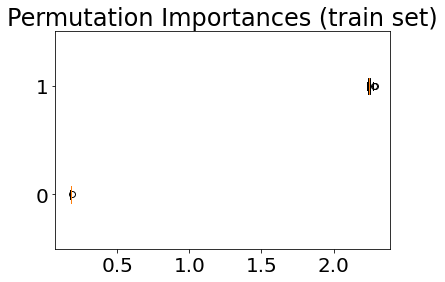

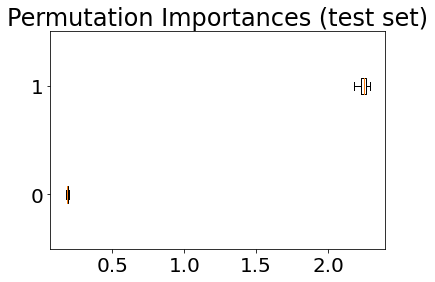

Best predicted R2 score (predict): 0.6014841781912552
Best predicted MAPE score (predict): 0.8275183714567247
Best predicted MdAPE score (predict): 741.1456817395583
Best predicted MSE score (predict): 1546252.5490638672
Best predicted MASE score (predict): 1.0


In [11]:
show_trend_season = ShowResults(
    models_base[0],
    X_train, X_test,
    y_train, y_test,
    time_columns_start=7,
    model_is_trend_season="yes",
    model_not_combined=True
)
show_trend_season.show_model_results(pred_base[0])

If your model is a <strong>residual model</strong> and no combined estimator, then you need this extra parameters:
- <code>model_not_combined=True</code>
- <strong><code>time_feats_in_res="yes"</code><strong>

Best trained parameters from the pipeline (fit): {'HistGradientBoostingRegressor__learning_rate': 0.02, 'HistGradientBoostingRegressor__max_bins': 128}
Best trained mean score (R2, RMSE, ..) from the n-folds of the pipeline (fit): 0.04668379037299966


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_HistGradientBoostingRegressor__learning_rate,param_HistGradientBoostingRegressor__max_bins,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,3.522087,0.612947,0.028504,0.004524,0.02,128,{'HistGradientBoostingRegressor__learning_rate...,0.023532,0.043309,0.034115,0.085780,0.046684,0.023632,1
1,4.096006,0.907669,0.032839,0.007243,0.1,128,{'HistGradientBoostingRegressor__learning_rate...,-0.068064,0.016473,0.019025,0.087301,0.013684,0.055087,2


preparing permutation importance plots ...


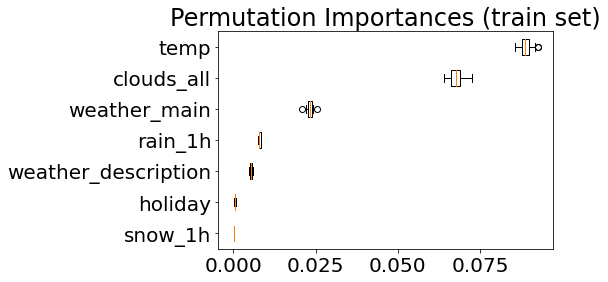

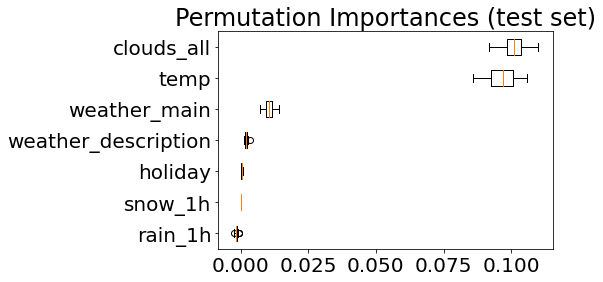

Best predicted R2 score (predict): 0.10530118610185935
Best predicted MAPE score (predict): 1.5692316105095414
Best predicted MdAPE score (predict): 1589.096004995948
Best predicted MSE score (predict): 3471456.4539883
Best predicted MASE score (predict): 1.0


In [12]:
show_residual = ShowResults(
    models_base[1],
    X_train, X_test,
    y_train, y_test,
    time_columns_start=7,
    model_not_combined=True
)
show_residual.show_model_results(pred_base[1])

We can clearly see, that the variance is mostly explained by the gaussian bumps (trend/season) model and not by the residual model<br>
Afterwards we call a few functions from the Baseline class to fit our three simple baseline models also. <br>
When all three baselines are fitted, you have 6 Models to compare with:
- a combined meta estimator
- two single models which combined formed the meta estimator
- three single baselines models (mean, last_observation, mean_regressor)<br>

<h3> Fitting Baseline Estimator</h3>


******************

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END .................................., score=-0.000 total time=   0.0s
[CV 2/4] END .................................., score=-0.000 total time=   0.0s
[CV 3/4] END .................................., score=-0.006 total time=   0.0s
[CV 4/4] END .................................., score=-0.006 total time=   0.0s
Best trained parameters from the pipeline (fit): {}
Best trained mean score (R2, RMSE, ..) from the n-folds of the pipeline (fit): -0.003046306896134887


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002857,0.000391,0.000945,0.0001,{},-0.00002,-0.00013,-0.006472,-0.005564,-0.003046,0.002989,1


preparing permutation importance plots ...


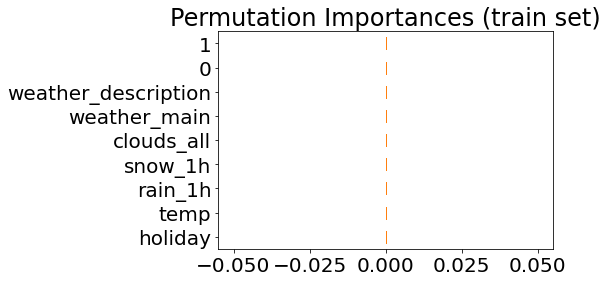

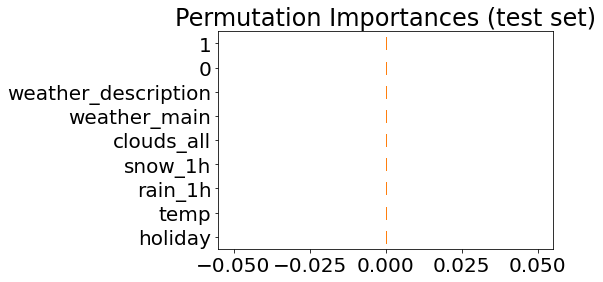

Best predicted R2 score (predict): -9.319998142132135e-06
Best predicted MAPE score (predict): 1.7142731532584714
Best predicted MdAPE score (predict): 1750.1803972323164
Best predicted MSE score (predict): 3880064.166879764
Best predicted MASE score (predict): 1.0

******************

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END .................................., score=-1.490 total time=   0.0s
[CV 2/4] END .................................., score=-1.465 total time=   0.0s
[CV 3/4] END .................................., score=-0.087 total time=   0.0s
[CV 4/4] END .................................., score=-0.329 total time=   0.0s
Best trained parameters from the pipeline (fit): {}
Best trained mean score (R2, RMSE, ..) from the n-folds of the pipeline (fit): -0.8426520748281118


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001851,0.00019,0.000859,0.000201,{},-1.489705,-1.465154,-0.086929,-0.328821,-0.842652,0.640571,1


preparing permutation importance plots ...


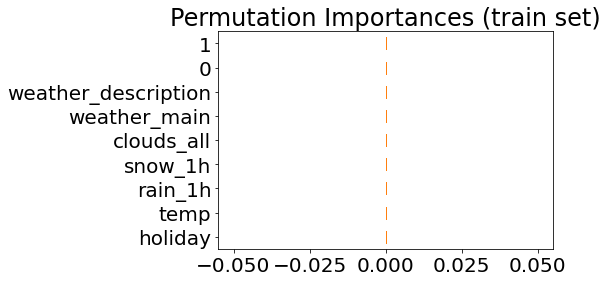

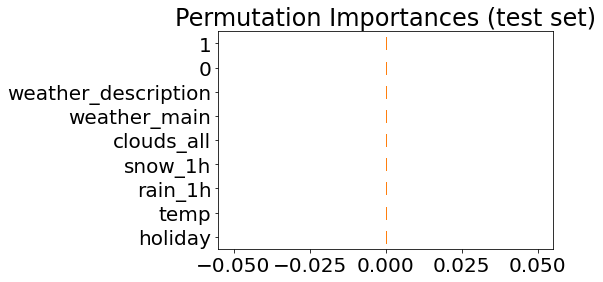

Best predicted R2 score (predict): -1.1126925652583535
Best predicted MAPE score (predict): 0.8604147745853716
Best predicted MdAPE score (predict): 2222.5
Best predicted MSE score (predict): 8197306.31921256
Best predicted MASE score (predict): 1.0

******************

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END .Rolling_Regressor__window_size=2;, score=-0.922 total time=   0.0s
[CV 2/4] END .Rolling_Regressor__window_size=2;, score=-0.888 total time=   0.0s
[CV 3/4] END .Rolling_Regressor__window_size=2;, score=-0.964 total time=   0.0s
[CV 4/4] END .Rolling_Regressor__window_size=2;, score=-1.007 total time=   0.0s
[CV 1/4] END .Rolling_Regressor__window_size=4;, score=-0.829 total time=   0.0s
[CV 2/4] END .Rolling_Regressor__window_size=4;, score=-0.782 total time=   0.0s
[CV 3/4] END .Rolling_Regressor__window_size=4;, score=-0.813 total time=   0.0s
[CV 4/4] END .Rolling_Regressor__window_size=4;, score=-0.940 total time=   0.0s
[CV 1/4] END .Rolling

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Rolling_Regressor__window_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,0.002444,0.000463,0.000541,0.000077,6,{'Rolling_Regressor__window_size': 6},-0.734082,-0.671992,-0.672586,-0.852112,-0.732693,0.073417,1
1,0.002481,0.000312,0.000541,0.000091,4,{'Rolling_Regressor__window_size': 4},-0.828922,-0.782062,-0.812800,-0.940243,-0.841007,0.059716,2
0,0.002735,0.000200,0.000711,0.000354,2,{'Rolling_Regressor__window_size': 2},-0.921832,-0.888125,-0.963592,-1.007132,-0.945170,0.044659,3


preparing permutation importance plots ...


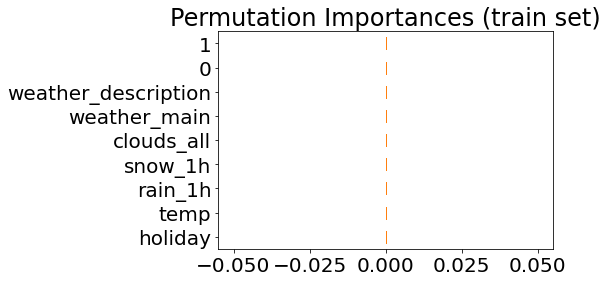

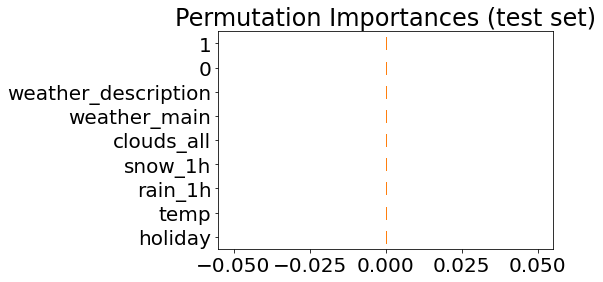

Best predicted R2 score (predict): -0.691458320546513
Best predicted MAPE score (predict): 1.8288066600862218
Best predicted MdAPE score (predict): 1767.25
Best predicted MSE score (predict): 6562905.653054656
Best predicted MASE score (predict): 1.0000000000000002


In [13]:
####### BASELINES #######
#baselines always r2 scoring

#mean model and results
mean_base, mean_preds = base.fit_an_predict_mean_baseline(verbose=5, scoring="r2")
show_base_mean = ShowResults(mean_base, X_train, X_test, y_train, y_test)
show_base_mean.show_model_results(mean_preds)

#last obs model and results
last_obs_base, last_obs_preds = base.fit_and_predict_last_obs_baseline(verbose=5, scoring="r2")
show_base_rolling = ShowResults(last_obs_base, X_train, X_test, y_train, y_test)
show_base_rolling.show_model_results(last_obs_preds)

#rolling model and results
window_size =[2, 4, 6]
rolling_base, rolling_preds = base.fit_and_predict_rolling_mean_baseline(window_size, verbose=5, scoring="r2")
show_base_last_obs = ShowResults(rolling_base, X_train, X_test, y_train, y_test)
show_base_last_obs.show_model_results(rolling_preds)

<h1> Documentation/Walkthrough Mlflow</h1>
All mlflow functions rely on the pipe_setup.json, keep in mind if you do not want to use mlflow you have to turn it off there.

In [14]:
# list experiments locally before mlflow connection
list_dead_mlflow_exps(100)

If Connection to mlflow is not up, the function looks locally
<Experiment: artifact_location='file:///Users/bormannp/OneDrive%20-%20Mediengruppe%20RTL/Program%20Planning/my-program-planning-research/PPP/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>
<Experiment: artifact_location='file:///Users/bormannp/OneDrive%20-%20Mediengruppe%20RTL/Program%20Planning/my-program-planning-research/PPP/mlruns/1', experiment_id='1', lifecycle_stage='active', name='your_experiment_name', tags={}>
<Experiment: artifact_location='file:///Users/bormannp/OneDrive%20-%20Mediengruppe%20RTL/Program%20Planning/my-program-planning-research/PPP/mlruns/2', experiment_id='2', lifecycle_stage='active', name='Experiment-Master-Ryu', tags={}>
<Experiment: artifact_location='file:///Users/bormannp/OneDrive%20-%20Mediengruppe%20RTL/Program%20Planning/my-program-planning-research/PPP/mlruns/3', experiment_id='3', lifecycle_stage='active', name='Experiment-onAir-I', tags={}>
<Experiment:

In [ ]:
# makes a clean sweep before start a new bunch of runs otherwise would add up to an experiment
# execute before mlflow running
# delete_all_runs_in_exp()

In [15]:
# checks if name exists in experiments, currently only works for non deleted exps, will be fixed in the future.
# Reason: there are several experiment catching function in mlflow, unfortunately the list_exp function only catches the
# visible ones. The get_experiment catches all and has to be looped
check_exp_name()

In [ ]:
# Keep in mind that json files only accept lower case bool (true/false) in the .json thus, you will find true instead of True
{
    "mlflow_start":{
    "usage":                    True, #turn on/off mlflow, decorator will then ignore the pipe_setup
    "uri":                      "https://mlflow-internal.onair.lab.da-service.io/",
    "experiment_name":          "your_exp_name",
    "artifact_storage":         "gs://mgr-onair-lab-2c1k-mlflow-lab/"
    }
}

In [ ]:
# You may change these:
{
    "mlflow_tags": {
    "fixed_parent_run": {
        "package version":    "buildpipe 0.1.a.",
        "target prediction":  "market_share",
        "project":            "onAIr",
        "task":               "experimental_task",
        "model_type":         "regression"
    }
    }
}

In [ ]:
# You should not change these:
{
    "automatic_parent_run": {
                "features":             "",
                "subestimator":         "",
                "window_class":         "",
                "window_train":         "",
                "window_test":          "",
                "window_sliding":       ""
          }
}
